Label construction + data sanitization

This notebook answers:

What is SOH?

What is RUL?

Which cycles are valid for learning?

How do we prevent leakage?

We first establish a robust charge–discharge based RUL model.
Impedance-aware modeling is treated as a secondary extension due to sparse and misaligned impedance measurements

In [2]:
import pandas as pd
import numpy as np
import pickle
import warnings
from pathlib import Path
from google.colab import drive
import matplotlib.pyplot as plt
import seaborn as sns

# warnings.filterwarnings('ignore')
# pd.set_option('display.max_columns', None)
# pd.set_option('display.precision', 4)

# Set random seed for reproducibility
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

In [3]:
drive.mount('/content/drive', force_remount=False)

Mounted at /content/drive


In [5]:
# Configure paths (MODIFY THESE TO YOUR FOLDER STRUCTURE)
BASE_PATH = Path('/content/drive/MyDrive/4 month project/DataSet')
INPUT_PATH = Path('/content/drive/MyDrive/4 month project/DataSet/multimodal_cycles-diksha(notebook2 output)')
OUTPUT_PATH = BASE_PATH / 'labeled-and-sanitized(notebook3 output)'

# Create output directory if it doesn't exist
OUTPUT_PATH.mkdir(parents=True, exist_ok=True)

print(f"\n✓ Base Path: {BASE_PATH}")
print(f"✓ Input Path: {INPUT_PATH}")
print(f"✓ Output Path: {OUTPUT_PATH}")

# Define input file
INPUT_FILE = INPUT_PATH / 'ALL_multimodal_cycles.csv'
print(f"\n✓ Input file: {INPUT_FILE}")

if not INPUT_FILE.exists():
    raise FileNotFoundError(f"❌ Input file not found: {INPUT_FILE}")


✓ Base Path: /content/drive/MyDrive/4 month project/DataSet
✓ Input Path: /content/drive/MyDrive/4 month project/DataSet/multimodal_cycles-diksha(notebook2 output)
✓ Output Path: /content/drive/MyDrive/4 month project/DataSet/labeled-and-sanitized(notebook3 output)

✓ Input file: /content/drive/MyDrive/4 month project/DataSet/multimodal_cycles-diksha(notebook2 output)/ALL_multimodal_cycles.csv


load multimodal data

In [6]:
def load_multimodal_data(input_file):
    """
    Load per-cycle multimodal dataset from Notebook-2.

    Returns:
        pd.DataFrame: Multimodal cycles data
    """
    print("\n" + "="*80)
    print("LOADING MULTIMODAL DATA")
    print("="*80)

    df = pd.read_csv(input_file)

    print(f"\n✓ Loaded data: {df.shape}")
    print(f"  Rows: {len(df):,}")
    print(f"  Columns: {len(df.columns)}")
    print(f"  Batteries: {df['battery_id'].nunique()}")

    print(f"\n📊 Column list:")
    for col in df.columns:
        print(f"  - {col} ({df[col].dtype})")

    print(f"\n📊 Preview:")
    print(df.head())

    return df

# Load data
df = load_multimodal_data(INPUT_FILE)


LOADING MULTIMODAL DATA

✓ Loaded data: (2794, 15)
  Rows: 2,794
  Columns: 15
  Batteries: 34

📊 Column list:
  - battery_id (object)
  - cycle_no (int64)
  - voltage_mean (float64)
  - voltage_min (float64)
  - voltage_max (float64)
  - temp_mean (float64)
  - discharge_time_sec (float64)
  - capacity_Ah (float64)
  - cap_delta (float64)
  - cap_delta_roll (float64)
  - chg_voltage_mean (float64)
  - chg_current_mean (float64)
  - chg_temp_mean (float64)
  - has_charge (int64)
  - has_impedance (int64)

📊 Preview:
  battery_id  cycle_no  voltage_mean  voltage_min  voltage_max  temp_mean  \
0      B0005         2        3.5322       2.8298       4.2219       24.0   
1      B0005         4        3.5373       2.8280       4.0571       24.0   
2      B0005         6        3.5437       2.8727       4.0563       24.0   
3      B0005         8        3.5437       2.8396       4.0562       24.0   
4      B0005        10        3.5424       2.8144       4.0575       24.0   

   discharge_t

structural validation

In [7]:
def validate_structure(df):
    """
    Validate dataset structure before any labeling.

    Checks:
    - No duplicate (battery_id, cycle_no)
    - Monotonic cycle numbers per battery
    - Basic statistics
    """
    print("\n" + "="*80)
    print("STRUCTURAL VALIDATION")
    print("="*80)

    # Check for required columns
    required_cols = ['battery_id', 'cycle_no', 'capacity_Ah']
    missing_cols = [col for col in required_cols if col not in df.columns]
    if missing_cols:
        raise ValueError(f"❌ Missing required columns: {missing_cols}")

    print(f"\n✓ Required columns present: {required_cols}")

    # Check for duplicates
    print(f"\n🔍 DUPLICATE CHECK:")
    duplicates = df.duplicated(subset=['battery_id', 'cycle_no']).sum()
    print(f"  Duplicate (battery_id, cycle_no) pairs: {duplicates}")

    if duplicates > 0:
        print("\n❌ CRITICAL ERROR: Duplicate entries found!")
        print(df[df.duplicated(subset=['battery_id', 'cycle_no'], keep=False)].head(20))
        raise AssertionError("Dataset contains duplicate (battery_id, cycle_no) pairs")

    print("  ✓ No duplicates found")

    # Check monotonicity
    print(f"\n🔍 MONOTONICITY CHECK:")
    non_monotonic_batteries = []

    for battery_id, battery_df in df.groupby('battery_id'):
        if not battery_df['cycle_no'].is_monotonic_increasing:
            non_monotonic_batteries.append(battery_id)
            print(f"  ⚠ Battery {battery_id}: non-monotonic cycles")

    if non_monotonic_batteries:
        raise AssertionError(f"❌ Non-monotonic cycles in batteries: {non_monotonic_batteries}")

    print("  ✓ All batteries have monotonic cycle numbers")

    # Basic statistics
    print(f"\n📊 DATASET STATISTICS:")
    print(f"  Total rows: {len(df):,}")
    print(f"  Total batteries: {df['battery_id'].nunique()}")

    cycles_per_battery = df.groupby('battery_id').size()
    print(f"\n📊 CYCLES PER BATTERY:")
    print(f"  Mean: {cycles_per_battery.mean():.1f}")
    print(f"  Median: {cycles_per_battery.median():.1f}")
    print(f"  Min: {cycles_per_battery.min()}")
    print(f"  Max: {cycles_per_battery.max()}")
    print(f"  Std: {cycles_per_battery.std():.1f}")

    print("\n✓ Structural validation passed")
    return True

# Validate structure
validate_structure(df)


STRUCTURAL VALIDATION

✓ Required columns present: ['battery_id', 'cycle_no', 'capacity_Ah']

🔍 DUPLICATE CHECK:
  Duplicate (battery_id, cycle_no) pairs: 0
  ✓ No duplicates found

🔍 MONOTONICITY CHECK:
  ✓ All batteries have monotonic cycle numbers

📊 DATASET STATISTICS:
  Total rows: 2,794
  Total batteries: 34

📊 CYCLES PER BATTERY:
  Mean: 82.2
  Median: 69.5
  Min: 25
  Max: 197
  Std: 56.4

✓ Structural validation passed


True

compute SOH

In [8]:
def compute_soh(df):
    """
    Compute State of Health (SOH) per battery.

    SOH = capacity_Ah / initial_capacity_Ah

    Rules:
    - No global normalization
    - No smoothing
    - No rolling averages
    - SOH starts near 1.0 and decays over cycles
    """
    print("\n" + "="*80)
    print("COMPUTING SOH (STATE OF HEALTH)")
    print("="*80)

    df = df.copy()
    df = df.sort_values(['battery_id', 'cycle_no'])

    # Compute initial capacity per battery
    initial_capacities = df.groupby('battery_id')['capacity_Ah'].first()
    print(f"\n📊 INITIAL CAPACITIES:")
    print(initial_capacities.sort_index())

    # Compute SOH
    df['initial_capacity'] = df['battery_id'].map(initial_capacities)
    df['SOH'] = df['capacity_Ah'] / df['initial_capacity']

    # Validation
    print(f"\n📊 SOH STATISTICS:")
    print(df['SOH'].describe())

    print(f"\n🔍 SOH VALIDATION:")

    # Check SOH range
    soh_min = df['SOH'].min()
    soh_max = df['SOH'].max()
    print(f"  SOH range: [{soh_min:.4f}, {soh_max:.4f}]")

    if soh_min < 0:
        print(f"  ⚠ WARNING: Negative SOH detected (min={soh_min:.4f})")

    if soh_max > 1.5:
        print(f"  ⚠ WARNING: SOH > 1.5 detected (max={soh_max:.4f})")

    # Check SOH decay per battery
    print(f"\n📊 SOH DECAY PER BATTERY:")
    for battery_id, battery_df in df.groupby('battery_id'):
        first_soh = battery_df['SOH'].iloc[0]
        last_soh = battery_df['SOH'].iloc[-1]
        decay = first_soh - last_soh
        print(f"  {battery_id}: {first_soh:.4f} → {last_soh:.4f} (decay: {decay:.4f})")

    # Drop temporary column
    df = df.drop(columns=['initial_capacity'])

    print("\n✓ SOH computation complete")
    return df

# Compute SOH
df = compute_soh(df)



COMPUTING SOH (STATE OF HEALTH)

📊 INITIAL CAPACITIES:
battery_id
B0005    0.0817
B0006    0.0817
B0007    0.0817
B0018    0.1521
B0025    0.2667
B0026    0.2667
B0027    0.2667
B0028    0.2667
B0029    0.0700
B0030    0.0700
B0031    0.0700
B0032    0.0700
B0033    0.0788
B0034    0.0788
B0036    0.0788
B0038    0.0429
B0039    0.0429
B0040    0.0429
B0041    0.0392
B0042    0.1487
B0043    0.1487
B0044    0.1487
B0045    0.2037
B0046    0.2037
B0047    0.2037
B0048    0.2037
B0049    0.0758
B0050    0.0758
B0051    0.0758
B0052    0.0758
B0053    0.0892
B0054    0.1162
B0055    0.1162
B0056    0.1162
Name: capacity_Ah, dtype: float64

📊 SOH STATISTICS:
count    2794.0000
mean        1.2270
std         0.9777
min         0.0072
25%         0.7915
50%         0.9817
75%         1.4660
max         6.3301
Name: SOH, dtype: float64

🔍 SOH VALIDATION:
  SOH range: [0.0072, 6.3301]
  ⚠ WARNING: SOH > 1.5 detected (max=6.3301)

📊 SOH DECAY PER BATTERY:
  B0005: 1.0000 → 1.5255 (decay: -0.52

define EOL

In [9]:
def define_eol(df, threshold=0.70):
    """
    Define End-of-Life (EOL) per battery.

    EOL = first cycle where SOH ≤ threshold

    Rules:
    - If battery never reaches threshold → last cycle is censored EOL
    - Document reached vs censored batteries
    """
    print("\n" + "="*80)
    print("DEFINING END-OF-LIFE (EOL)")
    print("="*80)

    print(f"\n  EOL Threshold: SOH ≤ {threshold}")

    df = df.copy()
    eol_cycles = {}
    eol_status = {}  # 'reached' or 'censored'

    for battery_id, battery_df in df.groupby('battery_id'):
        # Find first cycle where SOH <= threshold
        eol_mask = battery_df['SOH'] <= threshold

        if eol_mask.any():
            eol_cycle = battery_df.loc[eol_mask, 'cycle_no'].iloc[0]
            eol_cycles[battery_id] = eol_cycle
            eol_status[battery_id] = 'reached'
        else:
            # Censored - use last cycle
            eol_cycle = battery_df['cycle_no'].iloc[-1]
            eol_cycles[battery_id] = eol_cycle
            eol_status[battery_id] = 'censored'

    print(f"\n📊 EOL SUMMARY:")
    reached_count = sum(1 for status in eol_status.values() if status == 'reached')
    censored_count = sum(1 for status in eol_status.values() if status == 'censored')

    print(f"  Total batteries: {len(eol_cycles)}")
    print(f"  Reached EOL: {reached_count}")
    print(f"  Censored: {censored_count}")

    print(f"\n📊 EOL CYCLES PER BATTERY:")
    for battery_id in sorted(eol_cycles.keys()):
        status = eol_status[battery_id]
        eol_cycle = eol_cycles[battery_id]
        print(f"  {battery_id}: Cycle {eol_cycle} ({status})")

    # Add EOL information to dataframe
    df['eol_cycle'] = df['battery_id'].map(eol_cycles)
    df['eol_status'] = df['battery_id'].map(eol_status)

    print("\n✓ EOL definition complete")
    return df, eol_cycles, eol_status

# Define EOL
EOL_THRESHOLD = 0.70
df, eol_cycles, eol_status = define_eol(df, threshold=EOL_THRESHOLD)




DEFINING END-OF-LIFE (EOL)

  EOL Threshold: SOH ≤ 0.7

📊 EOL SUMMARY:
  Total batteries: 34
  Reached EOL: 17
  Censored: 17

📊 EOL CYCLES PER BATTERY:
  B0005: Cycle 614 (censored)
  B0006: Cycle 614 (censored)
  B0007: Cycle 614 (censored)
  B0018: Cycle 169 (reached)
  B0025: Cycle 78 (censored)
  B0026: Cycle 78 (censored)
  B0027: Cycle 78 (censored)
  B0028: Cycle 78 (censored)
  B0029: Cycle 94 (censored)
  B0030: Cycle 94 (censored)
  B0031: Cycle 94 (censored)
  B0032: Cycle 94 (censored)
  B0033: Cycle 483 (censored)
  B0034: Cycle 483 (censored)
  B0036: Cycle 483 (censored)
  B0038: Cycle 121 (censored)
  B0039: Cycle 121 (censored)
  B0040: Cycle 121 (censored)
  B0041: Cycle 10 (reached)
  B0042: Cycle 103 (reached)
  B0043: Cycle 103 (reached)
  B0044: Cycle 103 (reached)
  B0045: Cycle 51 (reached)
  B0046: Cycle 51 (reached)
  B0047: Cycle 51 (reached)
  B0048: Cycle 51 (reached)
  B0049: Cycle 41 (reached)
  B0050: Cycle 41 (reached)
  B0051: Cycle 41 (reached)
  B0

RUL

In [11]:
def compute_rul(df):
    """
    Compute Remaining Useful Life (RUL) per cycle.

    RUL = eol_cycle - cycle_no

    Validation:
    - RUL = 0 at EOL
    - RUL must be non-negative
    - RUL must decrease monotonically per battery
    """
    print("\n" + "="*80)
    print("COMPUTING RUL (REMAINING USEFUL LIFE)")
    print("="*80)

    df = df.copy()

    # Compute RUL
    df['RUL'] = df['eol_cycle'] - df['cycle_no']

    print(f"\n📊 RUL STATISTICS:")
    print(df['RUL'].describe())

    # Validation: RUL must be non-negative
    print(f"\n🔍 RUL VALIDATION:")
    negative_rul = (df['RUL'] < 0).sum()
    print(f"  Negative RUL count: {negative_rul}")

    if negative_rul > 0:
        print(f"\n  ⚠ WARNING: {negative_rul} cycles with negative RUL")
        print(df[df['RUL'] < 0][['battery_id', 'cycle_no', 'eol_cycle', 'RUL', 'SOH']].head(10))
        raise AssertionError("❌ CRITICAL: Negative RUL detected")

    print("  ✓ All RUL values are non-negative")

    # Validation: RUL = 0 at EOL
    print(f"\n🔍 EOL VALIDATION:")
    eol_rul_check = df[df['cycle_no'] == df['eol_cycle']]['RUL'].unique()
    print(f"  RUL at EOL cycles: {eol_rul_check}")

    if not all(rul == 0 for rul in eol_rul_check):
        raise AssertionError("❌ CRITICAL: RUL not equal to 0 at EOL")

    print("  ✓ RUL = 0 at all EOL cycles")

    # Validation: RUL decreases monotonically
    print(f"\n🔍 MONOTONICITY VALIDATION:")
    non_monotonic_batteries = []

    for battery_id, battery_df in df.groupby('battery_id'):
        # RUL should decrease (or stay constant in edge cases)
        rul_diff = battery_df['RUL'].diff()
        # Allow for constant RUL in first row (diff = NaN)
        if (rul_diff.dropna() > 0).any():
            non_monotonic_batteries.append(battery_id)
            print(f"  ⚠ Battery {battery_id}: non-monotonic RUL")

    if non_monotonic_batteries:
        raise AssertionError(f"❌ CRITICAL: Non-monotonic RUL in batteries: {non_monotonic_batteries}")

    print("  ✓ RUL decreases monotonically for all batteries")

    print(f"\n📊 RUL RANGE PER BATTERY:")
    for battery_id, battery_df in df.groupby('battery_id'):
        rul_min = battery_df['RUL'].min()
        rul_max = battery_df['RUL'].max()
        print(f"  {battery_id}: RUL range [{rul_min}, {rul_max}]")

    print("\n✓ RUL computation complete")
    return df

#%%
# =============================================================================
# SECTION 8: POST-EOL HANDLING
# =============================================================================

def handle_post_eol(df):
    """
    Handle cycles that occur after EOL.

    Rules:
    - Drop cycles after EOL
    - Keep EOL cycle itself
    - Log how many rows are removed
    """
    print("\n" + "="*80)
    print("POST-EOL HANDLING")
    print("="*80)

    initial_rows = len(df)
    print(f"\n  Initial rows: {initial_rows:,}")

    # Keep cycles <= EOL cycle
    df = df[df['cycle_no'] <= df['eol_cycle']].copy()

    final_rows = len(df)
    removed_rows = initial_rows - final_rows

    print(f"  Final rows: {final_rows:,}")
    print(f"  Removed rows: {removed_rows:,} ({removed_rows/initial_rows*100:.2f}%)")

    print(f"\n📊 CYCLES RETAINED PER BATTERY:")
    for battery_id, battery_df in df.groupby('battery_id'):
        print(f"  {battery_id}: {len(battery_df)} cycles (up to cycle {battery_df['cycle_no'].max()})")

    print("\n✓ Post-EOL handling complete")
    return df

# Handle post-EOL cycles FIRST, then compute RUL
df = handle_post_eol(df)
df = compute_rul(df)



POST-EOL HANDLING

  Initial rows: 2,794
  Final rows: 2,142
  Removed rows: 652 (23.34%)

📊 CYCLES RETAINED PER BATTERY:
  B0005: 168 cycles (up to cycle 614)
  B0006: 168 cycles (up to cycle 614)
  B0007: 168 cycles (up to cycle 614)
  B0018: 68 cycles (up to cycle 169)
  B0025: 28 cycles (up to cycle 78)
  B0026: 28 cycles (up to cycle 78)
  B0027: 28 cycles (up to cycle 78)
  B0028: 28 cycles (up to cycle 78)
  B0029: 40 cycles (up to cycle 94)
  B0030: 40 cycles (up to cycle 94)
  B0031: 40 cycles (up to cycle 94)
  B0032: 40 cycles (up to cycle 94)
  B0033: 197 cycles (up to cycle 483)
  B0034: 197 cycles (up to cycle 483)
  B0036: 197 cycles (up to cycle 483)
  B0038: 47 cycles (up to cycle 121)
  B0039: 47 cycles (up to cycle 121)
  B0040: 47 cycles (up to cycle 121)
  B0041: 5 cycles (up to cycle 10)
  B0042: 42 cycles (up to cycle 103)
  B0043: 42 cycles (up to cycle 103)
  B0044: 42 cycles (up to cycle 103)
  B0045: 20 cycles (up to cycle 51)
  B0046: 20 cycles (up to cycle

post EOL handling- data sanitization

In [13]:
def handle_post_eol(df):
    """
    Handle cycles that occur after EOL.

    Rules:
    - Drop cycles after EOL
    - Keep EOL cycle itself
    - Log how many rows are removed
    """
    print("\n" + "="*80)
    print("POST-EOL HANDLING")
    print("="*80)

    initial_rows = len(df)
    print(f"\n  Initial rows: {initial_rows:,}")

    # Keep cycles <= EOL cycle
    df = df[df['cycle_no'] <= df['eol_cycle']].copy()

    final_rows = len(df)
    removed_rows = initial_rows - final_rows

    print(f"  Final rows: {final_rows:,}")
    print(f"  Removed rows: {removed_rows:,} ({removed_rows/initial_rows*100:.2f}%)")

    print(f"\n📊 CYCLES RETAINED PER BATTERY:")
    for battery_id, battery_df in df.groupby('battery_id'):
        print(f"  {battery_id}: {len(battery_df)} cycles (up to cycle {battery_df['cycle_no'].max()})")

    print("\n✓ Post-EOL handling complete")
    return df

# Handle post-EOL cycles
df = handle_post_eol(df)

#%%
# =============================================================================
# SECTION 9: MINIMAL DATA SANITIZATION
# =============================================================================

def sanitize_data(df):
    """
    Apply minimal, defensible data cleaning.

    Remove rows where:
    - capacity_Ah <= 0
    - capacity_Ah is NaN

    NO smoothing, clipping, or outlier removal.
    """
    print("\n" + "="*80)
    print("MINIMAL DATA SANITIZATION")
    print("="*80)

    initial_rows = len(df)
    print(f"\n  Initial rows: {initial_rows:,}")

    # Track removals
    removal_log = {}

    # Remove rows with invalid capacity
    invalid_capacity = (df['capacity_Ah'] <= 0) | (df['capacity_Ah'].isna())
    removal_log['invalid_capacity'] = invalid_capacity.sum()
    df = df[~invalid_capacity].copy()

    print(f"\n📊 REMOVAL SUMMARY:")
    for reason, count in removal_log.items():
        print(f"  {reason}: {count} rows")

    final_rows = len(df)
    total_removed = initial_rows - final_rows

    print(f"\n  Final rows: {final_rows:,}")
    print(f"  Total removed: {total_removed:,} ({total_removed/initial_rows*100:.2f}%)")

    # Re-validate after cleaning
    print(f"\n🔍 POST-CLEANING VALIDATION:")
    print(f"  Batteries remaining: {df['battery_id'].nunique()}")
    print(f"  SOH range: [{df['SOH'].min():.4f}, {df['SOH'].max():.4f}]")
    print(f"  RUL range: [{df['RUL'].min()}, {df['RUL'].max()}]")

    print("\n✓ Data sanitization complete")
    return df

# Sanitize data
df = sanitize_data(df)



POST-EOL HANDLING

  Initial rows: 2,142
  Final rows: 2,142
  Removed rows: 0 (0.00%)

📊 CYCLES RETAINED PER BATTERY:
  B0005: 168 cycles (up to cycle 614)
  B0006: 168 cycles (up to cycle 614)
  B0007: 168 cycles (up to cycle 614)
  B0018: 68 cycles (up to cycle 169)
  B0025: 28 cycles (up to cycle 78)
  B0026: 28 cycles (up to cycle 78)
  B0027: 28 cycles (up to cycle 78)
  B0028: 28 cycles (up to cycle 78)
  B0029: 40 cycles (up to cycle 94)
  B0030: 40 cycles (up to cycle 94)
  B0031: 40 cycles (up to cycle 94)
  B0032: 40 cycles (up to cycle 94)
  B0033: 197 cycles (up to cycle 483)
  B0034: 197 cycles (up to cycle 483)
  B0036: 197 cycles (up to cycle 483)
  B0038: 47 cycles (up to cycle 121)
  B0039: 47 cycles (up to cycle 121)
  B0040: 47 cycles (up to cycle 121)
  B0041: 5 cycles (up to cycle 10)
  B0042: 42 cycles (up to cycle 103)
  B0043: 42 cycles (up to cycle 103)
  B0044: 42 cycles (up to cycle 103)
  B0045: 20 cycles (up to cycle 51)
  B0046: 20 cycles (up to cycle 51

leakage prevention check

In [14]:
def check_leakage(df):
    """
    Verify no features use future information.

    Checks:
    - No rolling features include future cycles
    - No RUL-derived signals in features
    - All features are computed from current or past cycles only
    """
    print("\n" + "="*80)
    print("LEAKAGE PREVENTION CHECK")
    print("="*80)

    # Identify potentially problematic columns
    leakage_suspects = []

    # Check for columns with 'roll', 'future', 'lead', 'ahead'
    for col in df.columns:
        col_lower = col.lower()
        if any(keyword in col_lower for keyword in ['future', 'lead', 'ahead', 'forward']):
            leakage_suspects.append(col)

    if leakage_suspects:
        print(f"\n⚠ POTENTIAL LEAKAGE SUSPECTS:")
        for col in leakage_suspects:
            print(f"  - {col}")
        print("\n  These columns will be DROPPED")
        df = df.drop(columns=leakage_suspects)
    else:
        print(f"\n✓ No obvious leakage suspects found")

    # Verify RUL is not in features (it's the target)
    feature_cols = [col for col in df.columns
                    if col not in ['battery_id', 'cycle_no', 'SOH', 'RUL', 'eol_cycle', 'eol_status']]

    print(f"\n📊 FEATURE COLUMNS ({len(feature_cols)}):")
    for col in feature_cols:
        print(f"  - {col}")

    # Check for RUL-derived features
    rul_derived = [col for col in feature_cols if 'rul' in col.lower()]
    if rul_derived:
        print(f"\n⚠ RUL-DERIVED FEATURES DETECTED:")
        for col in rul_derived:
            print(f"  - {col}")
        print("\n  These columns will be DROPPED")
        df = df.drop(columns=rul_derived)

    print("\n✓ Leakage prevention check complete")
    return df

# Check for leakage
df = check_leakage(df)


LEAKAGE PREVENTION CHECK

✓ No obvious leakage suspects found

📊 FEATURE COLUMNS (13):
  - voltage_mean
  - voltage_min
  - voltage_max
  - temp_mean
  - discharge_time_sec
  - capacity_Ah
  - cap_delta
  - cap_delta_roll
  - chg_voltage_mean
  - chg_current_mean
  - chg_temp_mean
  - has_charge
  - has_impedance

✓ Leakage prevention check complete


final dataset

In [15]:
def finalize_dataset(df):
    """
    Prepare final dataset for modeling.

    Dataset must contain:
    - All original per-cycle features
    - SOH
    - RUL
    - battery_id
    - cycle_no

    No scaling, encoding, or transformation.
    """
    print("\n" + "="*80)
    print("FINAL DATASET CONTRACT")
    print("="*80)

    # Ensure required columns are present
    required_cols = ['battery_id', 'cycle_no', 'SOH', 'RUL']
    missing_cols = [col for col in required_cols if col not in df.columns]

    if missing_cols:
        raise ValueError(f"❌ Missing required columns: {missing_cols}")

    print(f"\n✓ Required columns present: {required_cols}")

    # Remove temporary columns
    temp_cols = ['eol_cycle', 'eol_status']
    df = df.drop(columns=[col for col in temp_cols if col in df.columns])

    # Sort by battery and cycle
    df = df.sort_values(['battery_id', 'cycle_no']).reset_index(drop=True)

    print(f"\n📊 FINAL DATASET SUMMARY:")
    print(f"  Total rows: {len(df):,}")
    print(f"  Total batteries: {df['battery_id'].nunique()}")
    print(f"  Total features: {len(df.columns)}")

    print(f"\n📊 FEATURE BREAKDOWN:")
    print(f"  Identifiers: battery_id, cycle_no")
    print(f"  Labels: SOH, RUL")
    feature_cols = [col for col in df.columns
                    if col not in ['battery_id', 'cycle_no', 'SOH', 'RUL']]
    print(f"  Features: {len(feature_cols)}")

    print(f"\n📊 RUL DISTRIBUTION:")
    print(df['RUL'].describe())

    print(f"\n📊 SOH DISTRIBUTION:")
    print(df['SOH'].describe())

    print(f"\n📊 CYCLES PER BATTERY:")
    cycles_per_battery = df.groupby('battery_id').size()
    print(cycles_per_battery)

    print("\n✓ Dataset finalization complete")
    return df

# Finalize dataset
df = finalize_dataset(df)


FINAL DATASET CONTRACT

✓ Required columns present: ['battery_id', 'cycle_no', 'SOH', 'RUL']

📊 FINAL DATASET SUMMARY:
  Total rows: 2,142
  Total batteries: 34
  Total features: 17

📊 FEATURE BREAKDOWN:
  Identifiers: battery_id, cycle_no
  Labels: SOH, RUL
  Features: 13

📊 RUL DISTRIBUTION:
count    2142.0000
mean      169.9295
std       164.7514
min         0.0000
25%        40.0000
50%       100.0000
75%       278.0000
max       612.0000
Name: RUL, dtype: float64

📊 SOH DISTRIBUTION:
count    2142.0000
mean        1.3630
std         0.9863
min         0.0093
25%         0.8939
50%         1.0595
75%         1.5503
max         6.3301
Name: SOH, dtype: float64

📊 CYCLES PER BATTERY:
battery_id
B0005    168
B0006    168
B0007    168
B0018     68
B0025     28
B0026     28
B0027     28
B0028     28
B0029     40
B0030     40
B0031     40
B0032     40
B0033    197
B0034    197
B0036    197
B0038     47
B0039     47
B0040     47
B0041      5
B0042     42
B0043     42
B0044     42
B0045  

summary+ pickle


SAVING LABELED DATASET

✓ Dataset saved: /content/drive/MyDrive/4 month project/DataSet/labeled-and-sanitized(notebook3 output)/processed_cycles_labeled.pkl
  File size: 0.27 MB
  Rows: 2,142
  Columns: 17

🔍 VERIFICATION (reloading):
  Reloaded rows: 2,142
  Reloaded columns: 17
  Match: ✓

LABEL VISUALIZATION

✓ Visualization saved: /content/drive/MyDrive/4 month project/DataSet/labeled-and-sanitized(notebook3 output)/label_visualization.png


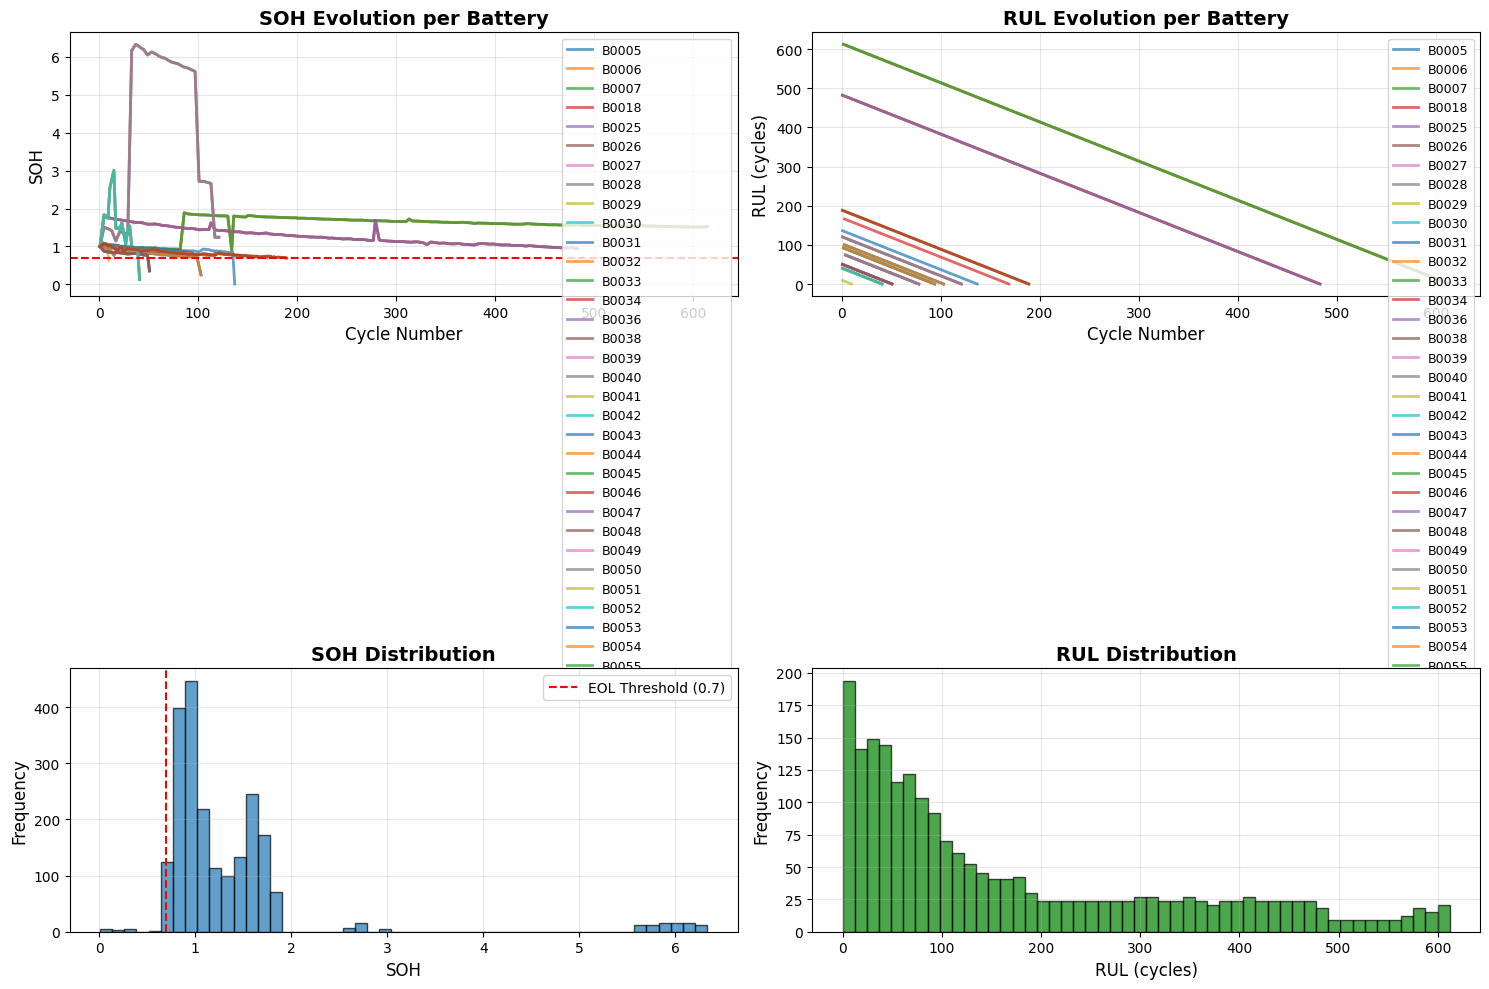

In [16]:
def save_labeled_dataset(df, output_path):
    """
    Save labeled dataset as single pickle artifact.

    Output: processed_cycles_labeled.pkl
    """
    print("\n" + "="*80)
    print("SAVING LABELED DATASET")
    print("="*80)

    output_file = output_path / 'processed_cycles_labeled.pkl'

    # Save as pickle
    with open(output_file, 'wb') as f:
        pickle.dump(df, f, protocol=pickle.HIGHEST_PROTOCOL)

    file_size = output_file.stat().st_size / 1024 / 1024

    print(f"\n✓ Dataset saved: {output_file}")
    print(f"  File size: {file_size:.2f} MB")
    print(f"  Rows: {len(df):,}")
    print(f"  Columns: {len(df.columns)}")

    # Verification: reload and check
    print(f"\n🔍 VERIFICATION (reloading):")
    with open(output_file, 'rb') as f:
        df_reloaded = pickle.load(f)

    print(f"  Reloaded rows: {len(df_reloaded):,}")
    print(f"  Reloaded columns: {len(df_reloaded.columns)}")
    print(f"  Match: {'✓' if len(df) == len(df_reloaded) else '❌'}")

    return output_file

# Save dataset
output_file = save_labeled_dataset(df, OUTPUT_PATH)

#%%
# =============================================================================
# SECTION 13: VISUALIZATION
# =============================================================================

def visualize_labels(df):
    """
    Visualize SOH and RUL distributions.
    """
    print("\n" + "="*80)
    print("LABEL VISUALIZATION")
    print("="*80)

    fig, axes = plt.subplots(2, 2, figsize=(15, 10))

    # 1. SOH evolution per battery
    for battery_id in df['battery_id'].unique():
        battery_df = df[df['battery_id'] == battery_id]
        axes[0, 0].plot(battery_df['cycle_no'], battery_df['SOH'],
                       label=battery_id, alpha=0.7, linewidth=2)
    axes[0, 0].axhline(y=EOL_THRESHOLD, color='r', linestyle='--',
                      label=f'EOL Threshold ({EOL_THRESHOLD})')
    axes[0, 0].set_xlabel('Cycle Number', fontsize=12)
    axes[0, 0].set_ylabel('SOH', fontsize=12)
    axes[0, 0].set_title('SOH Evolution per Battery', fontsize=14, fontweight='bold')
    axes[0, 0].legend(fontsize=9)
    axes[0, 0].grid(True, alpha=0.3)

    # 2. RUL evolution per battery
    for battery_id in df['battery_id'].unique():
        battery_df = df[df['battery_id'] == battery_id]
        axes[0, 1].plot(battery_df['cycle_no'], battery_df['RUL'],
                       label=battery_id, alpha=0.7, linewidth=2)
    axes[0, 1].set_xlabel('Cycle Number', fontsize=12)
    axes[0, 1].set_ylabel('RUL (cycles)', fontsize=12)
    axes[0, 1].set_title('RUL Evolution per Battery', fontsize=14, fontweight='bold')
    axes[0, 1].legend(fontsize=9)
    axes[0, 1].grid(True, alpha=0.3)

    # 3. SOH distribution
    axes[1, 0].hist(df['SOH'], bins=50, alpha=0.7, edgecolor='black')
    axes[1, 0].axvline(x=EOL_THRESHOLD, color='r', linestyle='--',
                      label=f'EOL Threshold ({EOL_THRESHOLD})')
    axes[1, 0].set_xlabel('SOH', fontsize=12)
    axes[1, 0].set_ylabel('Frequency', fontsize=12)
    axes[1, 0].set_title('SOH Distribution', fontsize=14, fontweight='bold')
    axes[1, 0].legend()
    axes[1, 0].grid(True, alpha=0.3)

    # 4. RUL distribution
    axes[1, 1].hist(df['RUL'], bins=50, alpha=0.7, edgecolor='black', color='green')
    axes[1, 1].set_xlabel('RUL (cycles)', fontsize=12)
    axes[1, 1].set_ylabel('Frequency', fontsize=12)
    axes[1, 1].set_title('RUL Distribution', fontsize=14, fontweight='bold')
    axes[1, 1].grid(True, alpha=0.3)

    plt.tight_layout()

    plot_file = OUTPUT_PATH / 'label_visualization.png'
    plt.savefig(plot_file, dpi=150, bbox_inches='tight')
    print(f"\n✓ Visualization saved: {plot_file}")
    plt.show()

# Generate visualizations
visualize_labels(df)


In [18]:

print("\n" + "="*80)
print("NOTEBOOK-3 COMPLETE ✓")
print("="*80)

print(f"\n📁 OUTPUT FILE:")
print(f"  {output_file}")

print(f"\n📊 FINAL DATASET:")
print(f"  Total rows: {len(df):,}")
print(f"  Batteries retained: {df['battery_id'].nunique()}")
print(f"  RUL range: [{df['RUL'].min()}, {df['RUL'].max()}]")
print(f"  SOH range: [{df['SOH'].min():.4f}, {df['SOH'].max():.4f}]")

print(f"\n📊 CYCLES PER BATTERY:")
for battery_id, battery_df in df.groupby('battery_id'):
    print(f"  {battery_id}: {len(battery_df)} cycles")


NOTEBOOK-3 COMPLETE ✓

📁 OUTPUT FILE:
  /content/drive/MyDrive/4 month project/DataSet/labeled-and-sanitized(notebook3 output)/processed_cycles_labeled.pkl

📊 FINAL DATASET:
  Total rows: 2,142
  Batteries retained: 34
  RUL range: [0, 612]
  SOH range: [0.0093, 6.3301]

📊 CYCLES PER BATTERY:
  B0005: 168 cycles
  B0006: 168 cycles
  B0007: 168 cycles
  B0018: 68 cycles
  B0025: 28 cycles
  B0026: 28 cycles
  B0027: 28 cycles
  B0028: 28 cycles
  B0029: 40 cycles
  B0030: 40 cycles
  B0031: 40 cycles
  B0032: 40 cycles
  B0033: 197 cycles
  B0034: 197 cycles
  B0036: 197 cycles
  B0038: 47 cycles
  B0039: 47 cycles
  B0040: 47 cycles
  B0041: 5 cycles
  B0042: 42 cycles
  B0043: 42 cycles
  B0044: 42 cycles
  B0045: 20 cycles
  B0046: 20 cycles
  B0047: 20 cycles
  B0048: 20 cycles
  B0049: 17 cycles
  B0050: 17 cycles
  B0051: 17 cycles
  B0052: 17 cycles
  B0053: 56 cycles
  B0054: 77 cycles
  B0055: 77 cycles
  B0056: 77 cycles
